## 4. Weather and Foursquare Location Data Analysis

In [1]:
# data processing
import pandas as pd 
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# database agent
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors

# calculate distance from coordinates
from geopy.distance import geodesic as GD

# env variables
import os
from dotenv import load_dotenv
load_dotenv()
database_credentials = {
    "username": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD")
}

# import maps package
import folium

# sys to add parent folder to path
import sys
sys.path.append("..")

from src.support_database_connection import connect_to_database, connect_and_query
from src.support_visualization import plot_line_labels, create_time_xticks

Now that the data has been loaded to the database, the goal is to analyse with the purpose of discovering insights that of impact to the business

## 4.1 Business case

Our organization is setting up a summer gymkana with the summer camp kids from the Community of Madrid. We are looking for a big space like a park, to set up the contests. Ideally, it should be a beautiful day with good weather, but not too hot. In the case of excessive heat, we could look for activities around to take the kids and still have fun while avoiding heat syncopes.

### 4.1.1 Find parks

First, let's evaluate how many parks there are available.

From the total of foursquare locations, more than 80% are parks. That starts making things easy.

In [2]:
query = "SELECT SUM(CASE WHEN category='Park' THEN 1 ELSE 0 END), COUNT(*) FROM foursquare_location;"
connect_and_query(database="modulo4_lab3", credentials_dict=database_credentials, query=query)

,0,1
0,663,822


### 4.1.2 Find what parks have a good weather

There were 2 criteria for determining what good weather means for our gymkana:
- A clear sky
- Not excessive heat

The first one can be quite straight-forward. However, taking into account that this activity will be carried out in end August, excessive heat will be tricky to avoid. 

To find a clear sky, let's re-check the categories for cielo to find the most interesting for our activity:

In [3]:
query= "SELECT DISTINCT cielo FROM weather;"
connect_and_query(database="modulo4_lab3", credentials_dict=database_credentials, query=query)

,0
0,Cubierto con lluvia
1,Nuboso con lluvia
2,Poco nuboso
3,Nuboso con lluvia escasa
4,Intervalos nubosos con lluvia escasa
5,Cielo despejado
6,Nubes altas
7,Bruma
8,Nuboso con tormenta y lluvia escasa
9,Cubierto


The weather categories that is desirable for us is; 'Cielo despejado'. Thus, let's find which parks have mostly 'Cielo despejado' as a sky state.

First, lest check what percentage of parks have a clear sky:

In [4]:
query="""SELECT CASE WHEN category='Park' THEN 'Park' 
                            ELSE 'Not a park' END,
                            CASE WHEN cielo='Cielo despejado' THEN 'Despejado' 
                            ELSE 'Not despejado' END, COUNT(*) 
               FROM foursquare_location fl
               INNER JOIN weather w 
                    ON w.id_municipio = fl.id_municipio
               GROUP BY CASE WHEN category='Park' THEN 'Park' 
                            ELSE 'Not a park' END,
                            CASE WHEN cielo='Cielo despejado' THEN 'Despejado' 
                            ELSE 'Not despejado' END;"""
connect_and_query(database="modulo4_lab3", credentials_dict=database_credentials, query=query)

,0,1,2
0,Not a park,Not despejado,6194
1,Not a park,Despejado,805
2,Park,Not despejado,26364
3,Park,Despejado,2903


The data does not allow for us to quickly see this as the numbers seen on the screen represent hourly data across approximatedly 2 days, thus it is better to see which parks have a majority of clear sky states throughout the day.

In [5]:
query= """SELECT location_name, municipio, m.id_municipio
                    FROM foursquare_location fl 
                    INNER JOIN municipios m 
                         ON m.id_municipio = fl.id_municipio
                    WHERE 
                              (SELECT cielo
                              FROM foursquare_location fl_sub
                              INNER JOIN weather w_sub
                                   ON fl_sub.id_municipio = w_sub.id_municipio
                              WHERE fl_sub.fsq_id = fl.fsq_id
                              GROUP BY location_name, cielo
                              ORDER BY COUNT(*) DESC
                              LIMIT 1) = 'Cielo despejado'
                              AND category = 'Park';"""
connect_and_query(database="modulo4_lab3", credentials_dict=database_credentials, query=query, columns=["Location_name","town","id_municipio"])

,Location_name,town,id_municipio
0,Parque Tierno Galván,San Martín de la Vega,id28132
1,Parque de la Estacion,San Martín de Valdeiglesias,id28133
2,El Bosque Encantado,San Martín de Valdeiglesias,id28133
3,Parque Central,Tres Cantos,id28903
4,Parque Antonio López,Tres Cantos,id28903
5,Parque Infantil Literatos 1,Tres Cantos,id28903
6,Parque Central Tres Cantos,Tres Cantos,id28903
7,Bike Park Tres Cantos,Tres Cantos,id28903
8,Parque infantil del castillo,Tres Cantos,id28903
9,Parque Infantil Descubridores 1,Tres Cantos,id28903


Tres Cantos quickly stands out, being the top town of the list. This is probably due to that city having many parks registered in foursquare, and having had a clear day weather forecast for our data.

Let's check its temperature distribution throughout the day:

In [6]:
query="""SELECT fecha, temp_celsius, sen_termica_celsius, municipio
                    FROM weather w
                    INNER JOIN municipios m 
                        ON m.id_municipio = w.id_municipio
                    WHERE w.id_municipio IN ('id28903','id28133','id28132')"""
hourly_temp_tres_cantos = connect_and_query(database="modulo4_lab3", credentials_dict=database_credentials, 
                  query=query, columns=["fecha_hora","temp_celsius","sensacion_termica_celsius","municipio"])

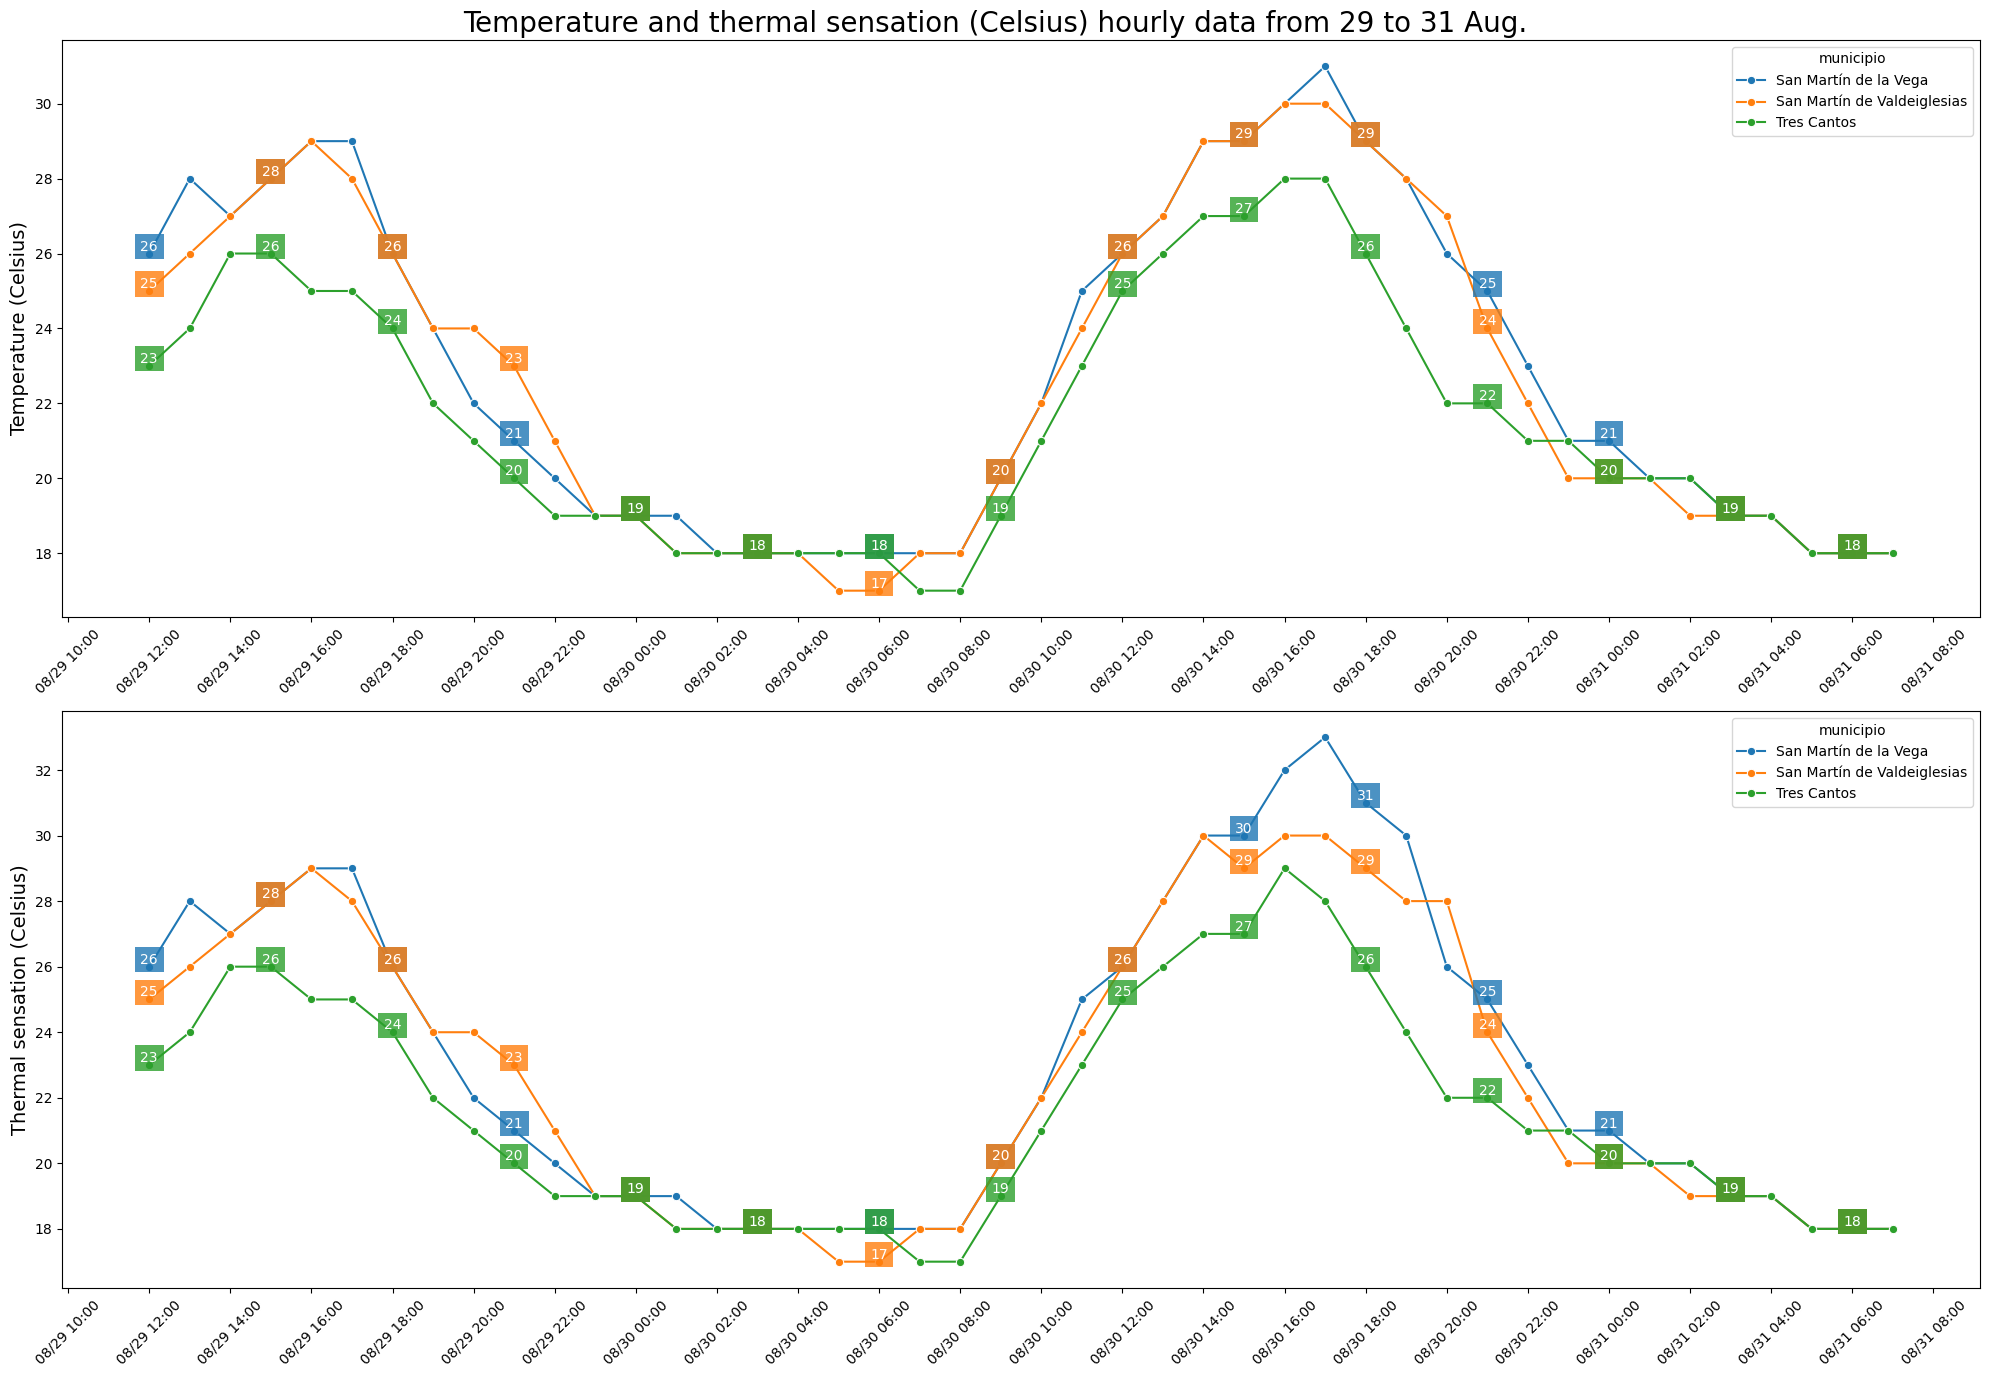

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 14)) 

plt.suptitle("Temperature and thermal sensation (Celsius) hourly data from 29 to 31 Aug.", fontsize=20)

##First plot
sns.lineplot(data=hourly_temp_tres_cantos,
             x="fecha_hora",
             y="temp_celsius",
             marker="o",
             hue="municipio",
             ax=ax1)

# adding data labels
plot_line_labels(ax1, interval=3)

# show hourly xticks
create_time_xticks(ax1, hour_interval=2)

ax1.set_ylabel("Temperature (Celsius)", fontsize=14)
ax1.set_xlabel(None)


## Second plot
sns.lineplot(data=hourly_temp_tres_cantos,
             x="fecha_hora",
             y="sensacion_termica_celsius",
             marker="o",
             hue="municipio",
             ax=ax2)

# adding data labels
plot_line_labels(ax2, interval=3)

# show hourly xticks
create_time_xticks(ax2, hour_interval=2)

ax2.set_ylabel("Thermal sensation (Celsius)", fontsize=14)
ax2.set_xlabel(None)

plt.tight_layout()
plt.show()

Tres cantos has the lowest temperature and thermal sensation of the 3 towns with a clear sky. Let's also check if there will be some breeze of air, a light wind, to refresh the kids while they run.



In [8]:
query="""SELECT fecha, velocidad_viento, municipio
                    FROM weather w
                    INNER JOIN municipios m 
                        ON m.id_municipio = w.id_municipio
                    WHERE w.id_municipio IN ('id28903','id28133','id28132')"""

hourly_wind_tres_cantos = connect_and_query(database="modulo4_lab3", credentials_dict=database_credentials, 
                                            query=query, columns=["fecha_hora","velocidad_viento","municipio"])

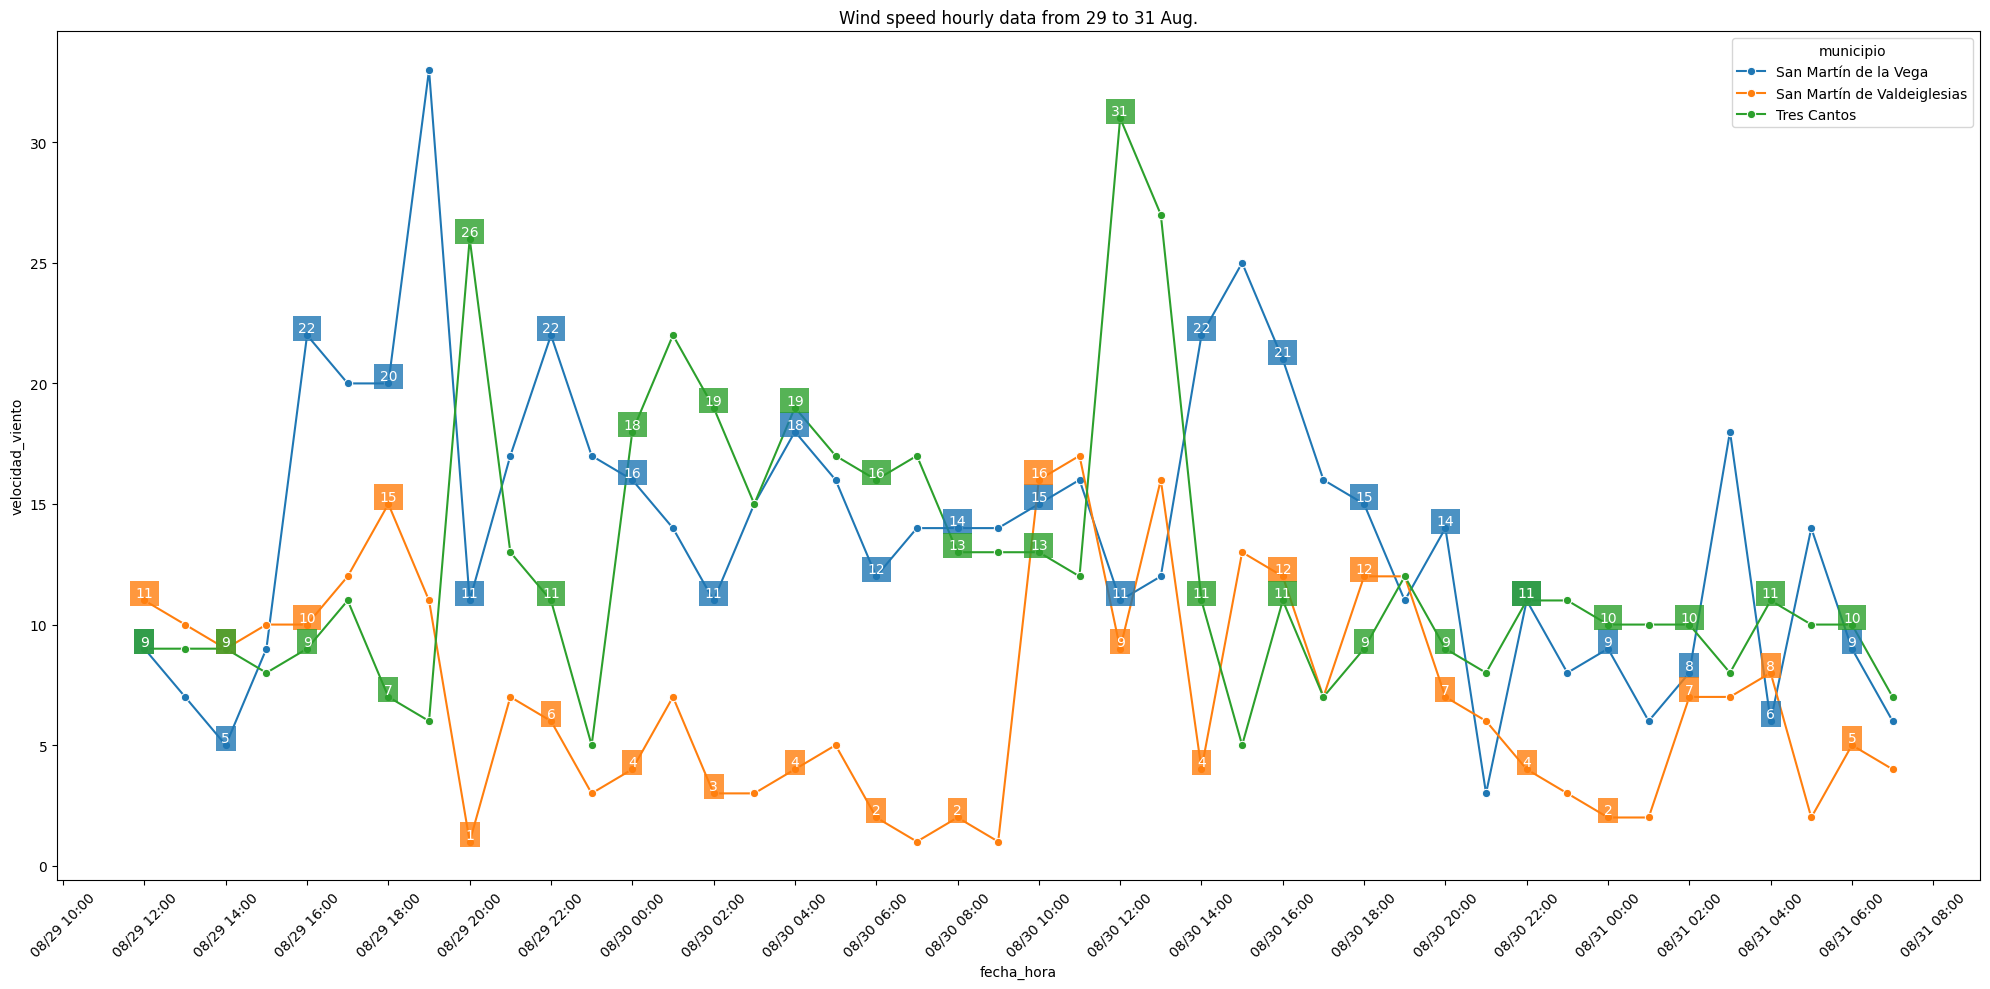

In [9]:
fig, ax = plt.subplots(figsize=(20,10))

plt.title("Wind speed hourly data from 29 to 31 Aug.")

# plotting the hourly data
sns.lineplot(data=hourly_wind_tres_cantos,
             x="fecha_hora",
             y="velocidad_viento",
             marker="o",
             hue="municipio",
             ax=ax)

# acessing line plot data points
plot_line_labels(ax, interval=2)

# writing the xticks hourly
create_time_xticks(ax, hour_interval=2)

plt.tight_layout()
plt.show()

The wind distribution seems more stable and moderate for tres cantos after 2PM, and might alleviate the heat a bit,. Before that, the wind speed might be too high and could interefere with the Gymkana.The above graph can get too overwhelming, so let's calculate the average wind speed per these municipios between noon and 6PM.

In [10]:
query="""
    SELECT municipio, ROUND(AVG(velocidad_viento),2), ROUND(STDDEV(velocidad_viento),2)
    FROM weather w
    INNER JOIN municipios m 
        ON m.id_municipio = w.id_municipio
    WHERE w.id_municipio IN ('id28903', 'id28133', 'id28132')
    AND fecha BETWEEN '2024-08-30 14:00:00' AND '2024-08-30 18:00:00'
    GROUP BY municipio
"""

connect_and_query(database="modulo4_lab3", credentials_dict=database_credentials, query=query, columns=["municipio","avg_velocidad_viento","std_velocidad_viento"])

,municipio,avg_velocidad_viento,std_velocidad_viento
0,San Martín de la Vega,19.80,4.21
1,San Martín de Valdeiglesias,9.60,3.91
2,Tres Cantos,8.60,2.61


As seen in the graph, the average wind speed for Tres Cantos is a bit smaller and also more stable after 2PM.

Nonetheless, just to be sure, it will be convenient to find activities close to the park, within a radius of max 1km in case it gets too hot. So from then on, it will be a matter of finding the park from all those that are available in Tres Cantos, that has the most or most interesting activities around as an alternative.

To make inspection easier to find nearby locations and find a good park space, we will make use of folium to plot the locations. First, let's extract the necessary table:

In [58]:
query = """SELECT fl.location_name location_name1, fl.id_municipio id_municipio1, fl.latitude latitude1, fl.longitude longitude1, fl2.location_name location_name2, fl2.category,fl2.latitude latitude2, fl2.longitude longitude2
FROM foursquare_location fl 
INNER JOIN foursquare_location fl2
    ON fl.fsq_id != fl2.fsq_id
WHERE 

    (6371 * acos( cos( radians(fl.latitude) ) 
    * cos( radians(fl2.latitude) ) 
    * cos( radians(fl2.longitude) - radians(fl.longitude) ) 
    + sin( radians(fl.latitude) ) 
    * sin( radians(fl2.latitude)))) < 1   -- > crossjoin where ids are not the same, filtered to be within 1km of each other.
  
  AND fl.id_municipio IN ('id28903','id28133','id28132')
  AND fl.category ='Park'
  AND fl2.category !='Park';"""
folium_df = connect_and_query(database="modulo4_lab3", credentials_dict=database_credentials, query=query, columns="query")
folium_df.head()

,location_name1,id_municipio1,latitude1,longitude1,location_name2,category,latitude2,longitude2
0,Parque de la Estacion,id28133,40.365381,-4.397472,Castillo de la Coracera,Castle,40.362616,-4.401297
1,Parque Central,id28903,40.607803,-3.708941,ACTION LIVE Tres Cantos,Monument,40.609043,-3.712564
2,Parque Antonio López,id28903,40.610468,-3.710426,ACTION LIVE Tres Cantos,Monument,40.609043,-3.712564
3,Parque Infantil Literatos 1,id28903,40.608659,-3.713187,ACTION LIVE Tres Cantos,Monument,40.609043,-3.712564
4,Parque Central Tres Cantos,id28903,40.610314,-3.712718,ACTION LIVE Tres Cantos,Monument,40.609043,-3.712564


In [64]:

# get coordinates of town were most parks are
query_location = "SELECT m.latitude, m.longitude FROM municipios m WHERE id_municipio = 'id28903';"
location = connect_and_query(database="modulo4_lab3", credentials_dict=database_credentials, query=query_location, columns="query")

# center around town location
mapa = folium.Map(
    location=[location["latitude"][0], location["longitude"][0]], 
    zoom_start=10, 
     tiles='openstreetmap',    
    attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'
)

## PLOT MAP
# Iterate over dataframe and customize tooltips
for index, row in folium_df.iterrows():

    # Determine color based on town
    if row["id_municipio1"] == 'id28903':
        icon_color = "blue"
    elif row["id_municipio1"] == 'id28133':
        icon_color = "green"
    elif row["id_municipio1"] == 'id28132':
        icon_color = "red"

    # Determine icons based on category
    if row["category"] == 'Castle':
        icon2 = "tower"
    elif row["category"] == 'Monument':
        icon2 = "flag"
    else:
        icon2 = "info-sign"
    

    # Crear un tooltip y popup más informativo
    tooltip_text = f"Category: {row['category']}"
    popup_text1 = f"""
    <b>Location:</b> {row['location_name1']}<br>
    """
    popup_text2 = f"""
    <b>Location:</b> {row['location_name2']}<br>
    """

    # Add marker of nearby location
    folium.Marker(
        location=[row["latitude2"], row["longitude2"]],
        tooltip=tooltip_text,
        popup=popup_text2,
        icon=folium.Icon(icon=icon2, color=icon_color)
    ).add_to(mapa)

    # Add marker of evaluated location
    folium.Marker(
        location=[row["latitude1"], row["longitude1"]],
        tooltip=None,
        popup=popup_text1,
        icon=folium.Icon(icon="star", color=icon_color)
    ).add_to(mapa)

# Save map in html
mapa.save('../maps/locations_map.html')

# Show map
mapa

Locations are in either:
- San Martin de Valdeiglesias
- or Tres Cantos

There was another town with clear sky parks, but did not have any locations at 1km distance.

The registered option from San Martín de Valdeiglesias is a small park, although from inspecting the map it is obvious that there is a big unregistered park called "Parque Chopera". That park can be just perfect for a gymkana, being located in a small and calm town. The alternative activity there is visiting a Castle, which can be very educational for the kids.

Coming to the second available town, Tres Cantos, we can see that there are numerous parks with other types of locations nearby. The biggest and thus most interesting option is "Parque Central", as it is vast and well connected. 

Alternative activities nearby "Parque Central" are either TV Stations or Monuments. TV Stations could be interesting for the kids if we manage to organise an event. The monuments are an incorrectly encoded as park and another castle, el 'Castillo de Soto de Viñuelas', which can be a great alternative after the activity.

Next to the castle there is another park that, although not registered in foursquare, is also big and connected to 'Soto de las Viñuelas', which opens a lot of opportunities for the gymkana.

Therefore, coming to an end of this analysis, the decision taken based on the data is to:
- Organize an event with the collaboration of and inside the 'Castillo de Soto de Viñuelas'. That way, the gymkana can be played from 12PM to 2PM within its premises to avoid the excessive speeds of air, but profiting from the fresher air.
- Lunch break from 2PM to 3PM.
- From 3PM to 5PM have small educational tour around the castle, with not so phisically intense activities.
- Finally, from 5PM to 7PM continue with the final trials of the gymkana and give the prizes to the winners.